In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [3]:
def rle_decode(mask_rle, shape=(320, 240, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

## Создание датафреймов

In [4]:
# Создадим датафрейм
train_image = []
train_image_mask = []
for img in os.listdir('data/train/'):
    train_image.append(img)
for img_mask in os.listdir('data/train_mask/'):
#     img_mask = cv2.imread('data/train_mask/{}'.format(img_mask),cv2.IMREAD_UNCHANGED)
#     img_mask = rle_encode(img_mask)
    train_image_mask.append(img_mask)

In [5]:
# Создадим валидационный датафрейм
valid_image = []
valid_image_mask = []
for img in os.listdir('data/valid/'):
    valid_image.append(img)
for img_mask in os.listdir('data/valid_mask/'):
#     img_mask = cv2.imread('data/valid_mask/{}'.format(img_mask),cv2.IMREAD_UNCHANGED)
#     img_mask = rle_encode(img_mask)
    valid_image_mask.append(img_mask)

In [6]:
d_tr = {'train_image': train_image, 'train_image_mask': train_image_mask}
train_df = pd.DataFrame(data=d_tr)
d_val = {'valid_image': valid_image, 'valid_image_mask': valid_image_mask}
valid_df = pd.DataFrame(data=d_val)

In [7]:
valid_df.head(1)

valid_image valid_image_mask
0    1315.jpg         1315.png

In [8]:
train_df.head(1)

train_image train_image_mask
0       0.jpg            0.png

## посмотрим картиночки

In [9]:
image, image_mask = train_df.iloc[2]
img = cv2.imread('data/train/{}'.format(image))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ####!!!!!!
mask = cv2.imread('data/train_mask/{}'.format(image_mask), 0)

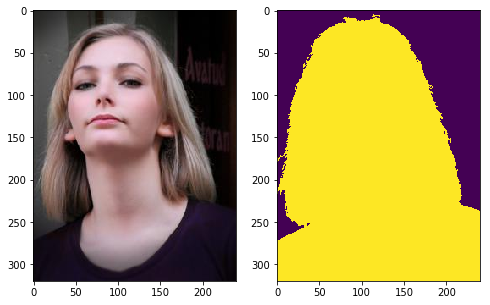

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 8))
axes[0].imshow(img)
axes[1].imshow(mask)
plt.show()

In [11]:
image_1, image_mask_1 = valid_df.iloc[2]
img_val = cv2.imread('data/valid/{}'.format(image_1))
img_val = cv2.cvtColor(img_val, cv2.COLOR_BGR2RGB)
mask_val = cv2.imread('data/valid_mask/{}'.format(image_mask_1), 0)

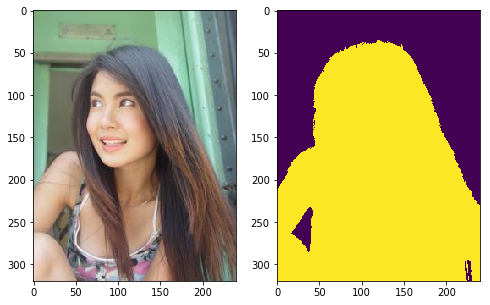

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 8))
axes[0].imshow(img_val)
axes[1].imshow(mask_val)
plt.show()

## Добавим аугментации

In [13]:
import albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
def strong_aug(p=0.8):
    return Compose([
        ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=45, p=0.8, border_mode=cv2.BORDER_CONSTANT),
         OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
         ], p=0.3),
        MedianBlur(blur_limit=3, p=0.7),
        OneOf([
            CLAHE(clip_limit=2, p=0.4),
            IAASharpen(p=0.4),
            IAAEmboss(p=0.4),
            RandomBrightnessContrast(p=0.6),
        HorizontalFlip(p=0.5)
        ])], p=p)

## задаем генераторы картинок

In [14]:
def keras_generator(gen_df, batch_size):
    """пишем генератор, чтобы не хранить все картинки в оперативной памяти"""
    while True:
        x_batch = []
        y_batch = []
        
        for i in range (batch_size):
            try:
                img_name, img_mask = gen_df.sample().values[0]
                img = cv2.imread('data/train/{}'.format(img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = cv2.imread('data/train_mask/{}'.format(img_mask), 0)
     
            except Exception as e:
                pass
#         меняем размер картинок
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
#         добавим аугментации
            augmentation = strong_aug(p=1)
            data = {"image": img.astype('uint8'), "mask": mask}
            augmented = augmentation(**data)
            img, mask = augmented["image"], augmented["mask"]

#            добавляем картинки в батч 
            x_batch += [img]
            y_batch += [mask]

#         нормируем картинки
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 255.
        
        yield x_batch, np.expand_dims(y_batch, -1)

In [15]:
def keras_generator_2 (gen_df, batch_size):
    """пишем генератор, чтобы не хранить все картинки в оперативной памяти"""
    while True:
        x_val_batch = []
        y_val_batch = []
        
        for i in range (batch_size):
            try:
                img_name, img_mask = gen_df.sample(1).values[0]
                img = cv2.imread('data/valid/{}'.format(img_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = cv2.imread('data/valid_mask/{}'.format(img_mask), 0)
            
            except Exception as e:
                pass
#         меняем размер картинок
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))

#            добавляем картинки в батч 
            x_val_batch += [img]
            y_val_batch += [mask]
            
#         нормируем картинки
        x_val_batch = np.array(x_val_batch) / 255.
        y_val_batch = np.array(y_val_batch) / 255.
        
        yield x_val_batch, np.expand_dims(y_val_batch, -1)

In [16]:
for x, y in keras_generator_2(valid_df, valid_df['valid_image'].count()):
    break

In [17]:
# проверяем, все ли грамотно у нас считалось
print(x.shape, y.shape)

(145, 256, 256, 3) (145, 256, 256, 1)


#### Проверим предположение о том, что у нас неравномерно распределен размер человека и фона на картинке

In [18]:
print(np.count_nonzero(y) / y.size)

0.5786824193494073


## Строим модель

In [19]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Aleksey\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [20]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
conv1 = base_model.get_layer('activation_1').output
conv2 = base_model.get_layer('activation_10').output
conv3 = base_model.get_layer('activation_22').output
conv4 = base_model.get_layer('activation_40').output
conv5 = base_model.get_layer('activation_49').output

up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('sigmoid')(conv_conc_5)


In [22]:
model = Model(input=base_model.input, output=conv_conc_5)

C:\Users\Aleksey\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  """Entry point for launching an IPython kernel.


## Функции потерь

In [23]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

## Метрика 

In [24]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(y_true, y_pred):
    # Tensorflow version
    return K.tf.py_func(get_iou_vector, [y_true, y_pred > 0.5], K.tf.float64)

In [25]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(loss = weighted_bce_dice_loss, optimizer = adam, metrics = [my_iou_metric])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [26]:
batch_size = 4
history = model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator_2(valid_df, batch_size),
              validation_steps=40,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 58s 579ms/step - loss: 0.6209 - my_iou_metric: 0.6505 - val_loss: 0.3690 - val_my_iou_metric: 0.8600
Epoch 2/100
100/100 [==============================] - 43s 431ms/step - loss: 0.3681 - my_iou_metric: 0.8202 - val_loss: 0.3496 - val_my_iou_metric: 0.8512
Epoch 3/100
100/100 [==============================] - 44s 436ms/step - loss: 0.3469 - my_iou_metric: 0.8353 - val_loss: 0.3020 - val_my_iou_metric: 0.8831
Epoch 4/100
100/100 [==============================] - 44s 440ms/step - loss: 0.2900 - my_iou_metric: 0.8675 - val_loss: 0.2902 - val_my_iou_metric: 0.8919
Epoch 5/100
100/100 [==============================] - 44s 444ms/step - loss: 0.2623 - my_iou_metric: 0.8775 - val_loss: 0.2295 - val_my_iou_metric: 0.9244
Epoch 6/100
100/100 [==============================] - 46s 456ms/step - loss: 0.2606 - my_iou_metric: 0.8827 - val_loss: 0.2450 - val_my_iou_metric: 0.9087
Epoch 7/100
100/100 [==============================] - 46s 455ms

100/100 [==============================] - 45s 448ms/step - loss: 0.1691 - my_iou_metric: 0.9555 - val_loss: 0.2090 - val_my_iou_metric: 0.9425
Epoch 54/100
100/100 [==============================] - 49s 493ms/step - loss: 0.1664 - my_iou_metric: 0.9597 - val_loss: 0.1951 - val_my_iou_metric: 0.9488
Epoch 55/100
100/100 [==============================] - 46s 456ms/step - loss: 0.1668 - my_iou_metric: 0.9562 - val_loss: 0.1804 - val_my_iou_metric: 0.9587
Epoch 56/100
100/100 [==============================] - 48s 481ms/step - loss: 0.1696 - my_iou_metric: 0.9472 - val_loss: 0.2039 - val_my_iou_metric: 0.9331
Epoch 57/100
100/100 [==============================] - 46s 462ms/step - loss: 0.1596 - my_iou_metric: 0.9643 - val_loss: 0.1976 - val_my_iou_metric: 0.9369
Epoch 58/100
100/100 [==============================] - 46s 455ms/step - loss: 0.1701 - my_iou_metric: 0.9475 - val_loss: 0.1957 - val_my_iou_metric: 0.9431
Epoch 59/100
100/100 [==============================] - 47s 466ms/step 

## Сделаем прогноз

In [27]:
val = sorted(os.listdir('data/valid/'))
val_mask = sorted(os.listdir('data/valid_mask/'))

In [28]:
list_of = []
for i in val:
    img = cv2.imread('data/valid/{}'.format(i))
    img = cv2.resize(img, (256, 256))
    list_of.append(img / 255.)
test_list = np.array(list_of)

In [29]:
list_of_mask = []
for i in val_mask:
    img = cv2.imread('data/valid_mask/{}'.format(i), 0)
    np.expand_dims(img, -1)
#     img_re = cv2.resize(img, (256, 256))
    list_of_mask.append(img)
# test_mask_list = np.array(list_of_mask)

In [30]:
pred_t = model.predict(test_list)

In [32]:
pred_list = []
for i in range (145):
    pred = cv2.resize(pred_t[i], (240, 320))
    pred_list.append(pred.round())
# test_list = np.array(pred_list)

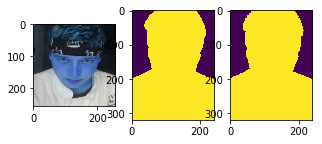

None 0


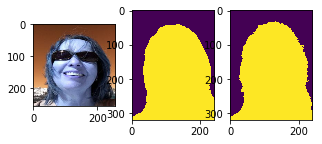

None 1


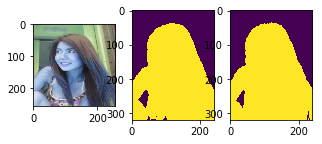

None 2


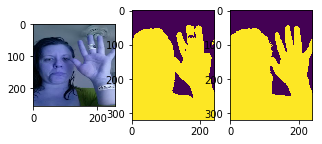

None 3


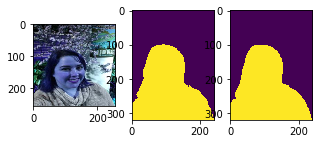

None 4


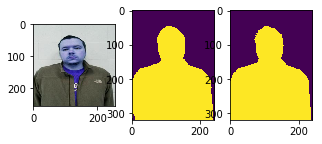

None 5


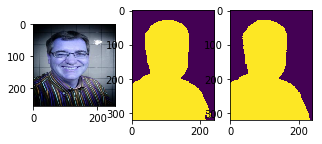

None 6


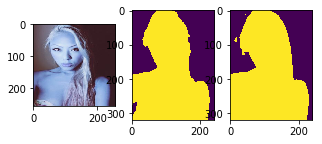

None 7


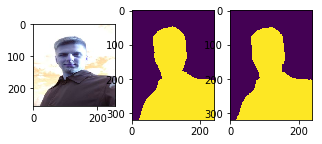

None 8


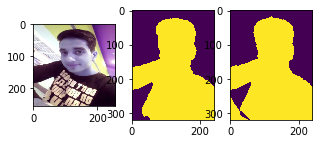

None 9


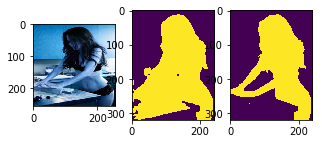

None 10


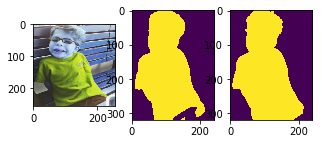

None 11


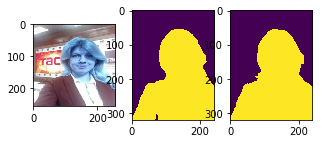

None 12


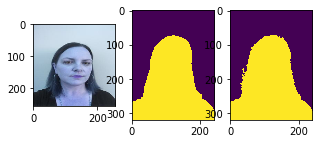

None 13


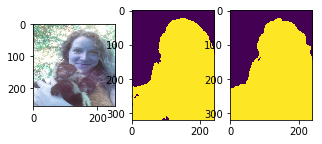

None 14


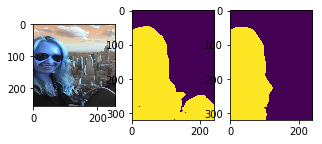

None 15


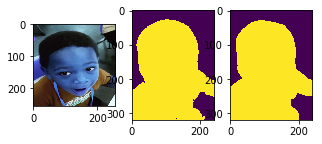

None 16


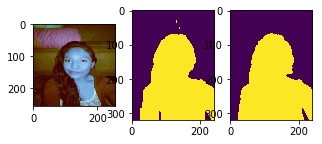

None 17


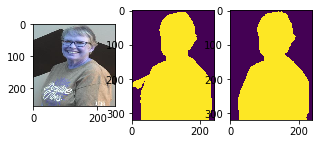

None 18


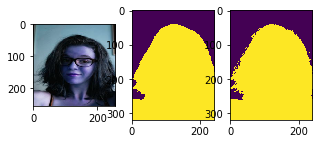

None 19


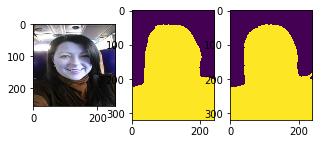

None 20


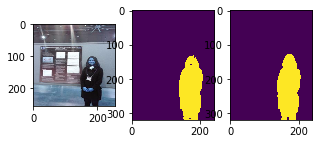

None 21


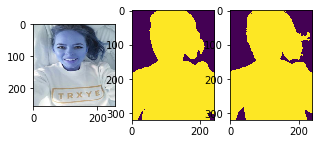

None 22


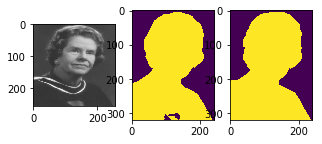

None 23


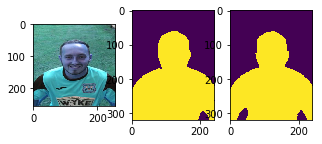

None 24


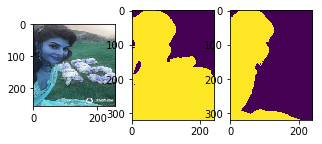

None 25


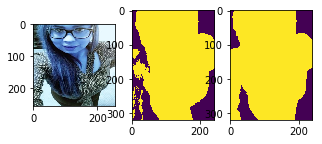

None 26


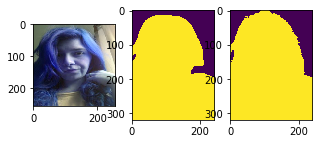

None 27


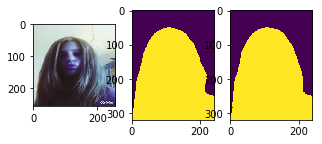

None 28


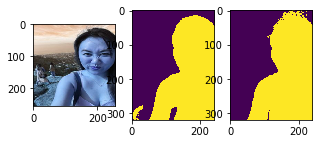

None 29


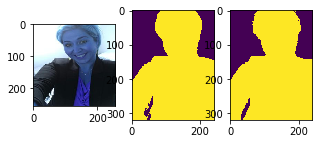

None 30


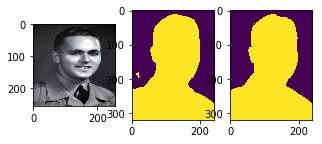

None 31


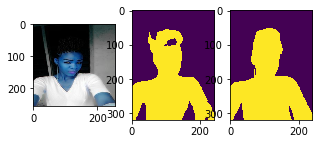

None 32


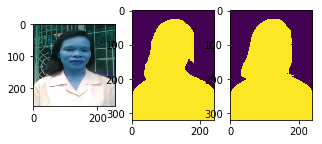

None 33


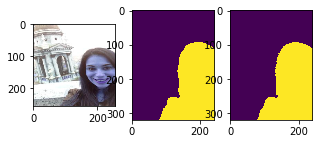

None 34


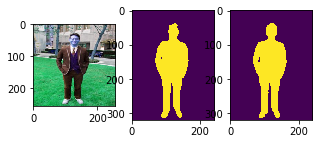

None 35


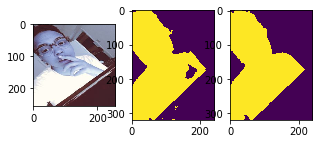

None 36


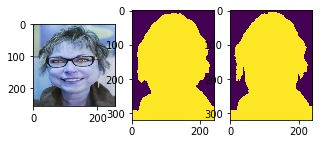

None 37


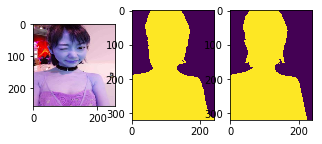

None 38


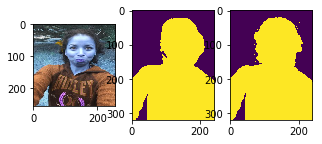

None 39


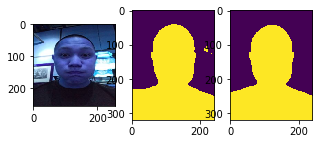

None 40


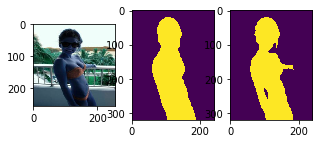

None 41


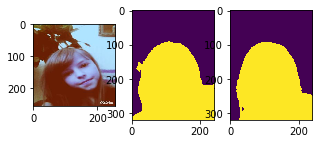

None 42


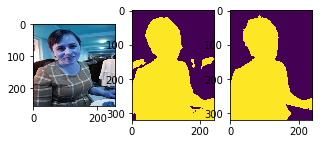

None 43


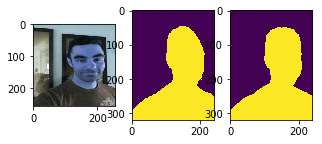

None 44


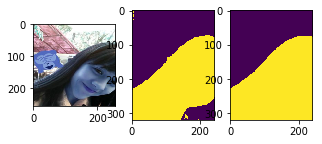

None 45


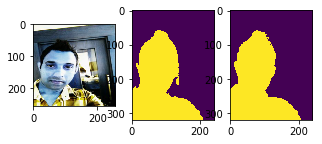

None 46


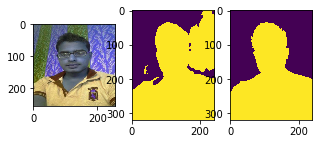

None 47


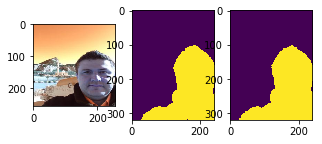

None 48


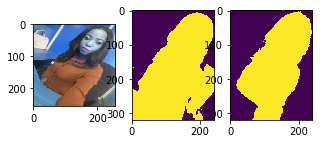

None 49


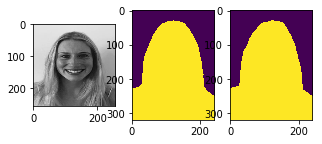

None 50


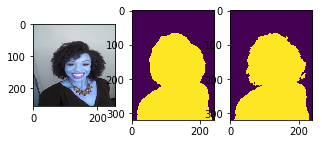

None 51


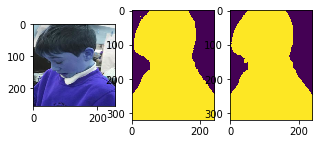

None 52


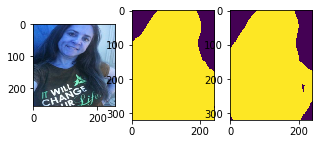

None 53


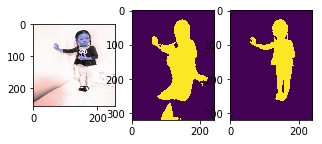

None 54


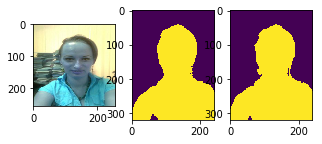

None 55


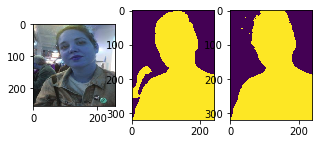

None 56


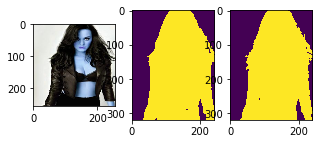

None 57


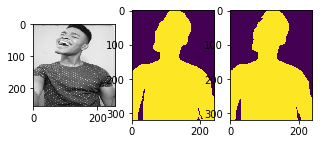

None 58


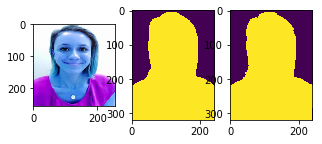

None 59


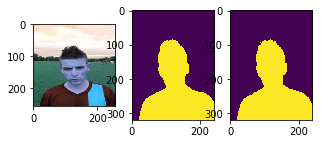

None 60


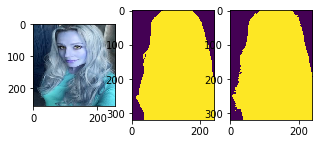

None 61


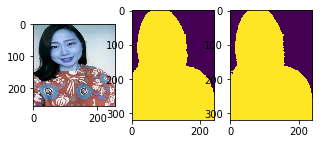

None 62


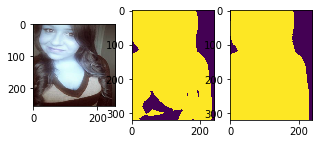

None 63


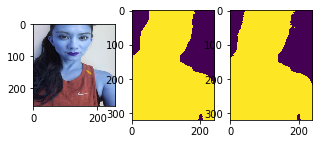

None 64


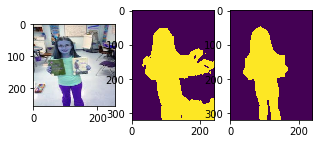

None 65


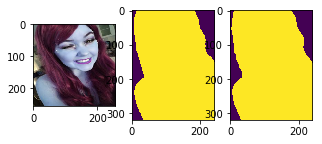

None 66


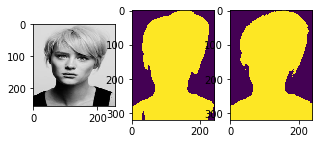

None 67


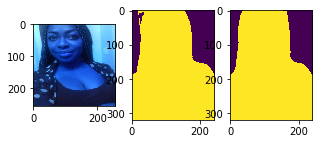

None 68


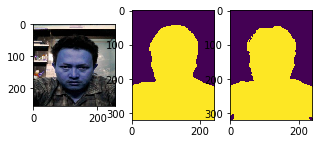

None 69


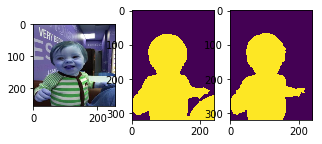

None 70


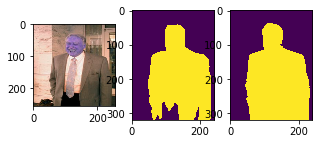

None 71


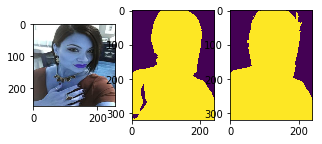

None 72


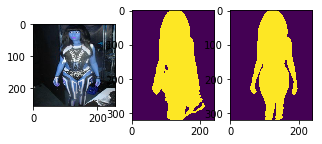

None 73


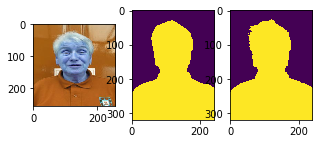

None 74


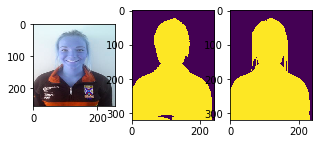

None 75


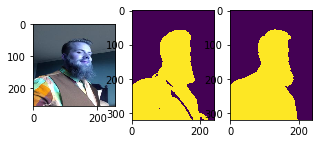

None 76


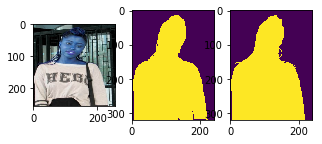

None 77


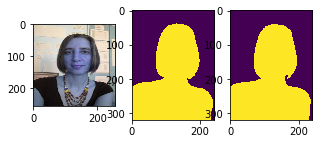

None 78


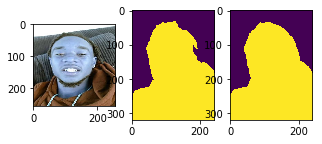

None 79


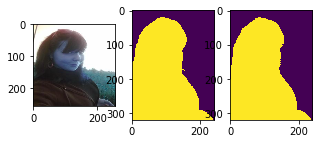

None 80


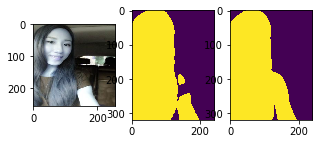

None 81


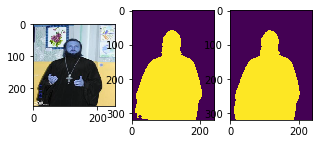

None 82


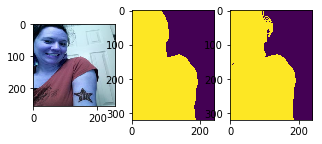

None 83


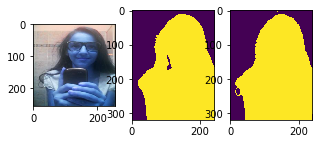

None 84


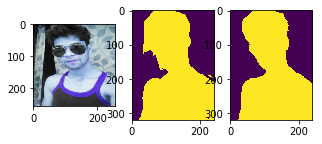

None 85


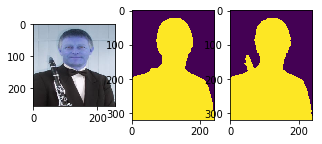

None 86


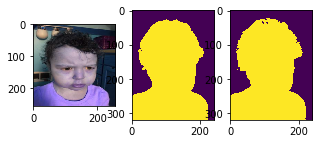

None 87


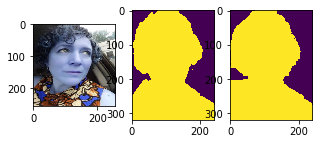

None 88


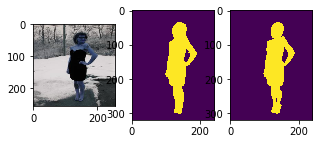

None 89


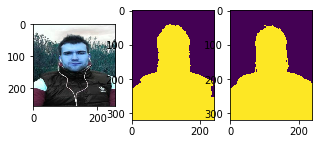

None 90


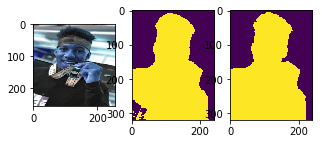

None 91


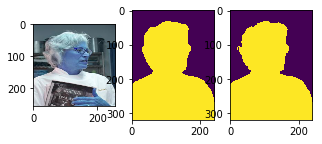

None 92


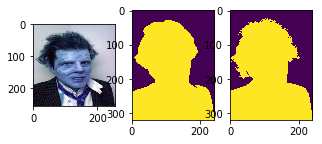

None 93


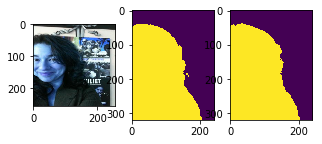

None 94


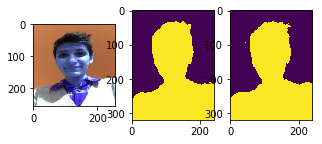

None 95


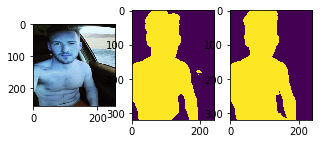

None 96


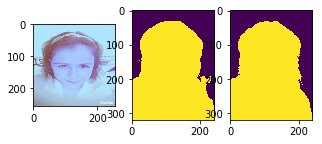

None 97


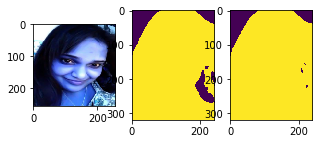

None 98


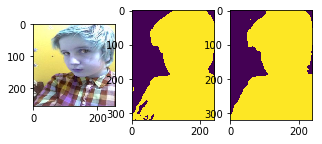

None 99


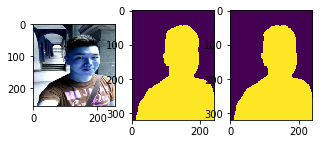

None 100


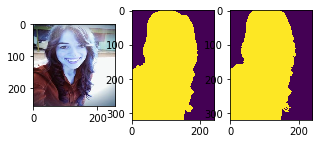

None 101


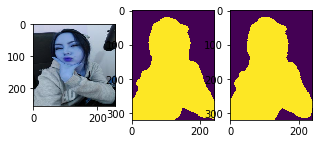

None 102


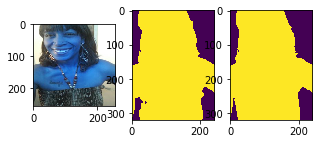

None 103


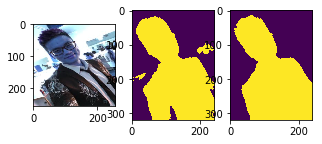

None 104


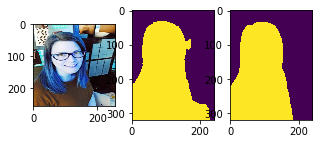

None 105


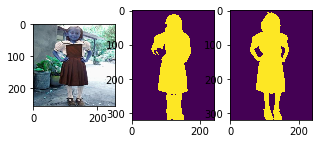

None 106


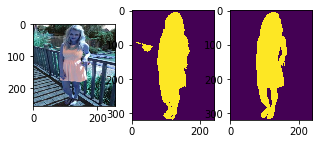

None 107


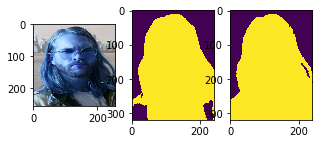

None 108


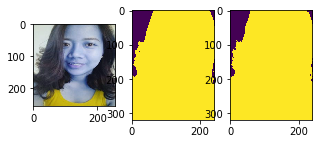

None 109


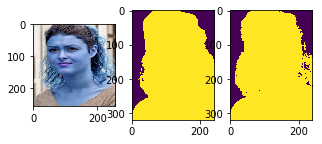

None 110


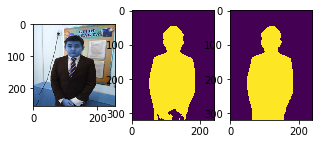

None 111


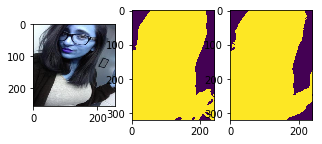

None 112


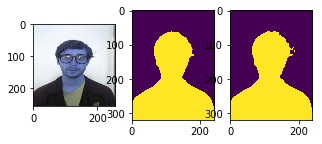

None 113


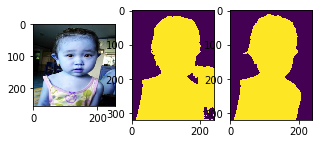

None 114


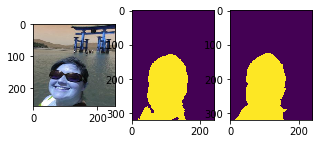

None 115


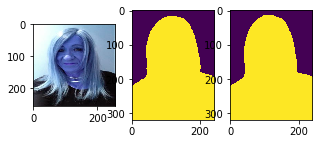

None 116


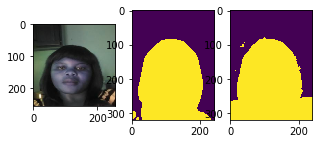

None 117


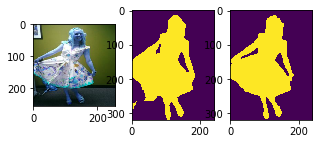

None 118


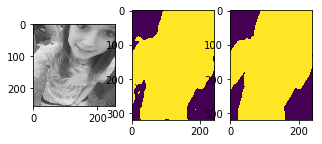

None 119


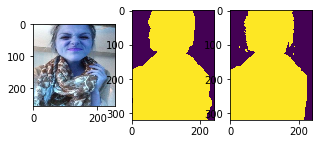

None 120


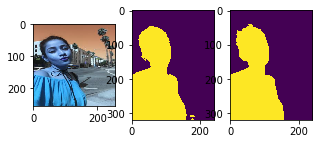

None 121


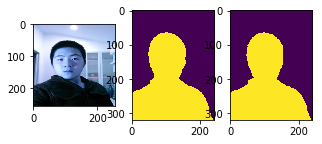

None 122


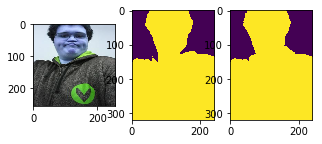

None 123


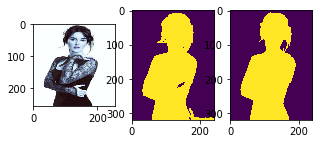

None 124


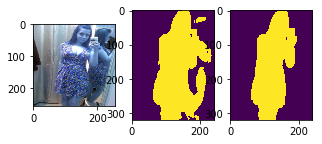

None 125


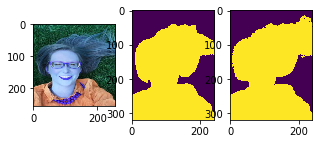

None 126


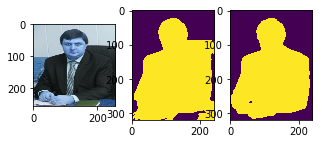

None 127


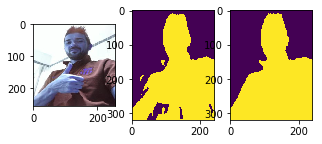

None 128


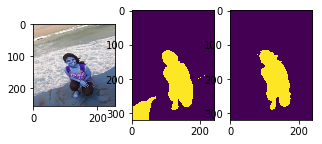

None 129


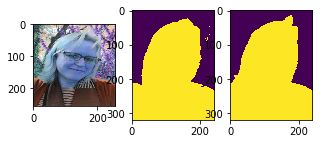

None 130


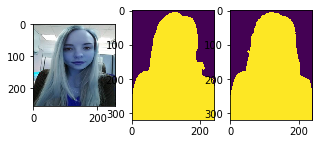

None 131


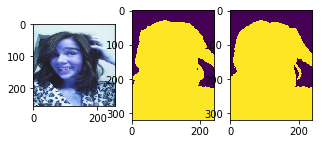

None 132


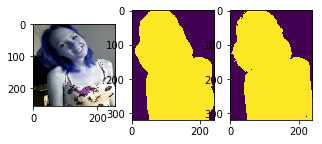

None 133


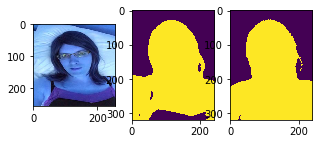

None 134


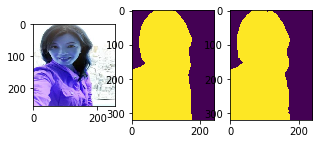

None 135


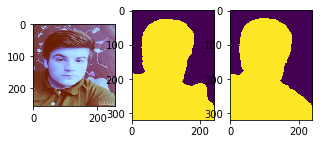

None 136


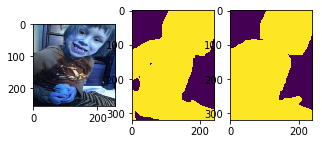

None 137


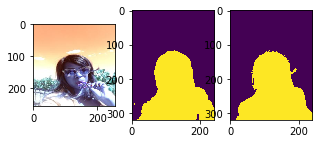

None 138


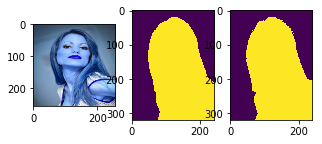

None 139


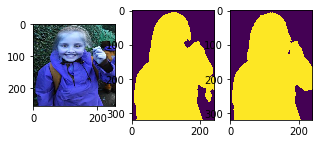

None 140


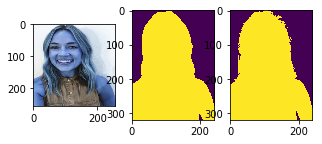

None 141


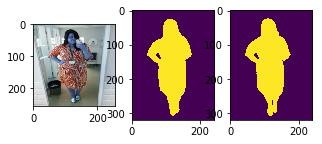

None 142


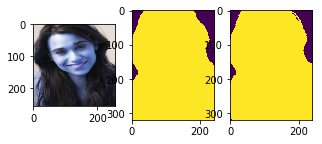

None 143


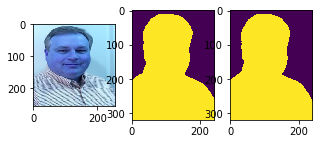

None 144


In [33]:
# im_id = 10

for im_id in range (y.shape[0]):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 5))
    axes[0].imshow(list_of[im_id])
    axes[1].imshow(pred_list[im_id])
    axes[2].imshow(list_of_mask[im_id])

    print(plt.show(), im_id)

## ошибка dice

In [34]:
EPS = 1e-10


def dice(true, pred):
    """Dice score.
    Parameters
    ----------
    true : np.ndarray, 2d
         Ground truth mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.
    pred : np.ndarray, 2d
         Predicted mask that consists of 2 unique values: 0 - denotes background,
         1 - denotes object.
    Returns
    -------ф
    float from 0 to 1
        Dice score. The greater the value of dice score the better.
    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).
    """
    true = true.astype(bool)
    pred = pred.astype(bool)

    intersection = (true & pred).sum()
    im_sum = true.sum() + pred.sum()

    return 2.0 * intersection / (im_sum + EPS)

In [35]:
def get_dice(true, pred):
    """Mean dice score.
    Parameters
    ----------
    true : list[np.ndarray] or np.ndarray
         List of ground truth masks or one mask that consists of 2 unique values:
         0 - denotes background, 1 - denotes object.
    pred : list[np.ndarray] or np.ndarray
         List of predicted masks or one mask that consists of 2 unique values:
         0 - denotes background, 1 - denotes object.
    Returns
    -------
    float from 0 to 1
        Dice score or mean dice score in case then lists of masks are passed.
        The greater the value of dice score the better.
    Notes
    -----
    Masks should contains only 2 unique values, one of them must be 0, another value, that denotes
    object, could be different from 1 (for example 255).
    
    """
    assert type(true) == type(pred), "Types of true and pred should be the same."
    if isinstance(true, list):
        return np.mean([dice(t, p) for t, p in zip(true, pred)])
    elif isinstance(true, np.ndarray):
        return dice(true, pred)
    else:
        raise TypeError("Wrong type.")

In [36]:
get_dice(list_of_mask, pred_list)

0.9695610490116986

In [39]:
from keras.callbacks import History 

In [40]:
print(history.history.keys())

dict_keys(['val_loss', 'val_my_iou_metric', 'loss', 'my_iou_metric'])


In [41]:
import matplotlib.pyplot as plt

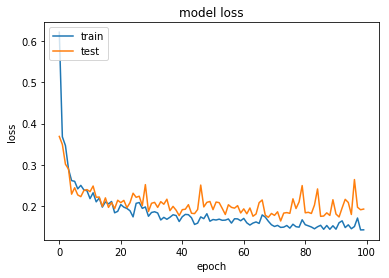

In [42]:
# график потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

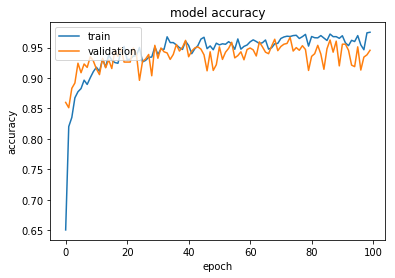

In [43]:
# график точность прогноза
plt.plot(history.history['my_iou_metric'])
plt.plot(history.history['val_my_iou_metric'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Сохраним результаты validation

In [44]:
im_num_counter = 1315
rle_mask = []
im_id = []
for i in pred_list:
    mask = rle_encode(i)
    rle_mask.append(mask)
    im_id.append(im_num_counter)
    im_num_counter+=1

In [45]:
d_pred = {'id': im_id, 'rle_mask': rle_mask}
pred_valid_template = pd.DataFrame(data=d_pred)

In [46]:
pred_valid_template.to_csv('data/pred_valid_template.csv', index=False)

In [48]:
great_job = pd.read_csv("data/pred_valid_template.csv")
great_job.tail()

id                                           rle_mask
140  1455  1557 8 1794 16 2030 22 2268 28 2504 33 2742 36...
141  1456  823 11 1059 17 1281 9 1296 22 1518 15 1535 24 ...
142  1457  6107 7 6344 14 6582 18 6820 22 7059 24 7298 27...
143  1458  36 141 275 143 515 144 754 146 994 146 1233 14...
144  1459  2725 30 2960 40 3197 46 3435 51 3672 60 3910 6...

## Проведем проверку на тестовой выборке

In [49]:
test_nums = sorted(os.listdir('data/test/'))

In [50]:
list_of_test = []
for i in test_nums:
    img = cv2.imread('data/test/{}'.format(i))
    img = cv2.resize(img, (256, 256))
    list_of_test.append(img / 255.)
test_list_of_tests = np.array(list_of_test)

In [51]:
pred_test_111 = model.predict(test_list_of_tests)

In [52]:
pred_list_tests = []
for i in range (100):
    pred = cv2.resize(pred_test_111[i], (240, 320))
    pred_list_tests.append(pred.round())
final_list_of_tests = np.array(pred_list_tests)

In [53]:
for i in range (len(pred_list_tests)):
    for j in range (len(pred_list_tests[i])):
        pred_list_tests[i][j] = pred_list_tests[i][j]*255

In [54]:
for i in range (1460, 1560):
    cv2.imwrite('C:/Users/Aleksey/Desktop/my_project/data/test_mask/' + str(i) +'.png', pred_list_tests[i-1460])

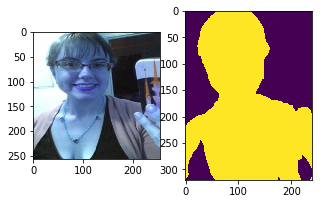

None 0


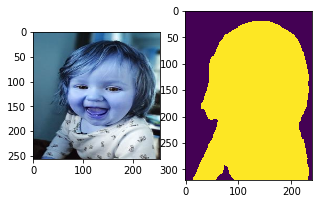

None 1


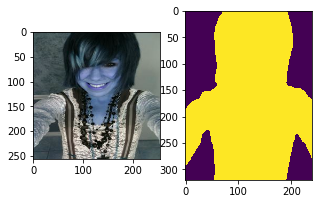

None 2


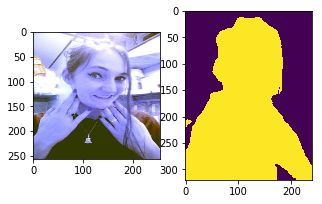

None 3


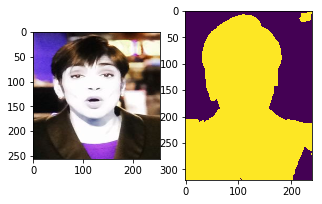

None 4


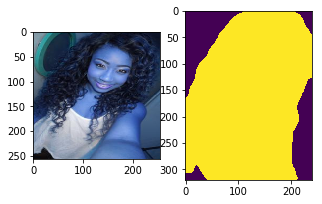

None 5


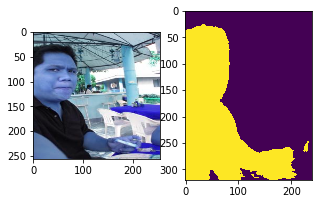

None 6


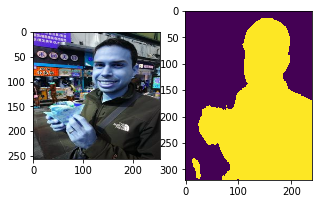

None 7


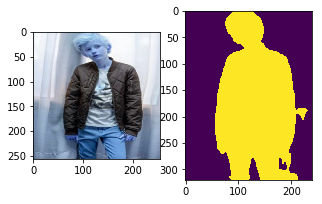

None 8


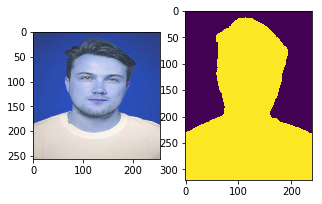

None 9


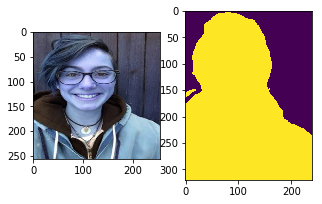

None 10


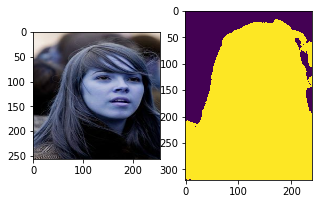

None 11


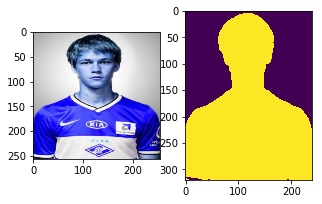

None 12


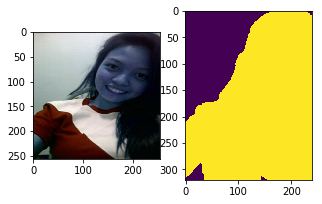

None 13


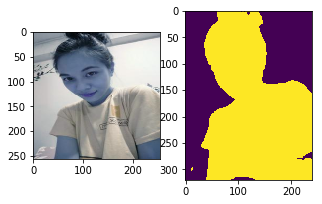

None 14


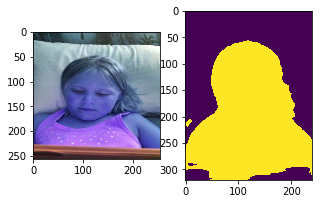

None 15


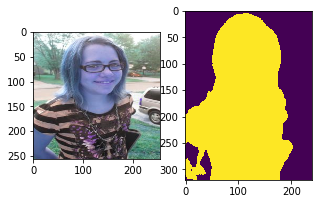

None 16


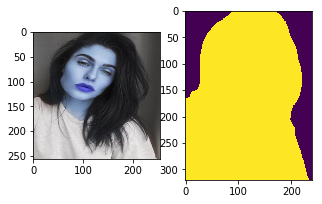

None 17


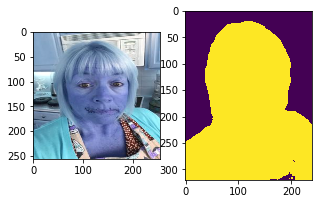

None 18


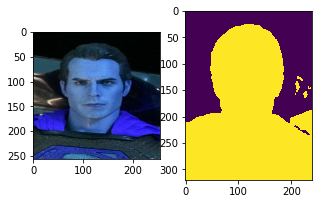

None 19


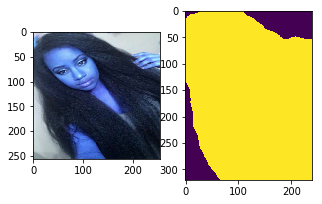

None 20


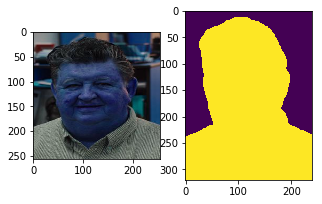

None 21


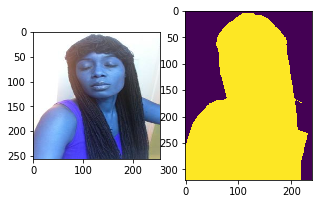

None 22


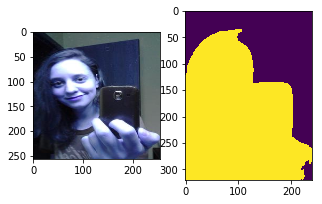

None 23


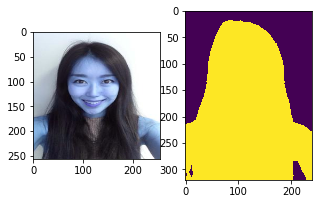

None 24


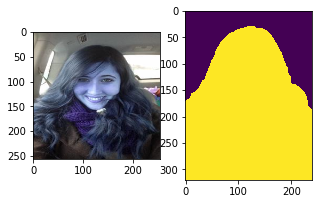

None 25


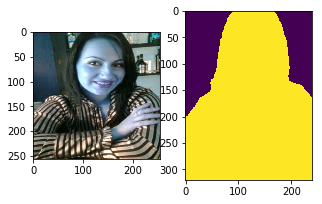

None 26


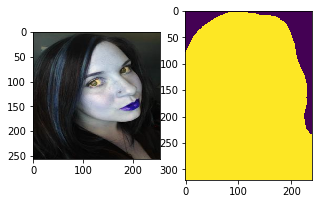

None 27


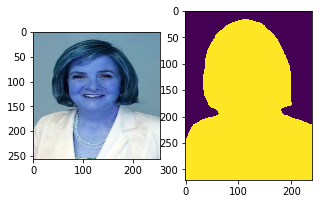

None 28


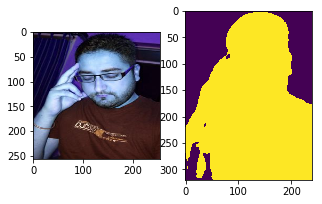

None 29


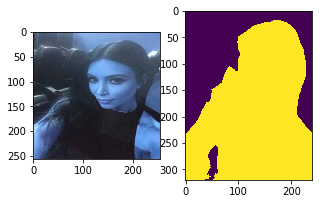

None 30


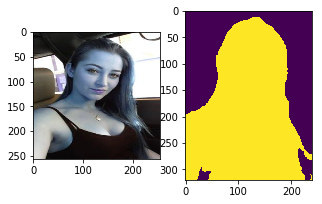

None 31


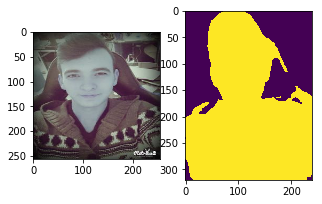

None 32


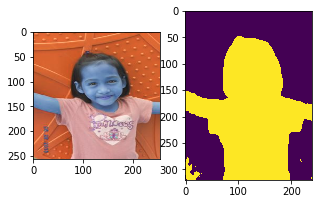

None 33


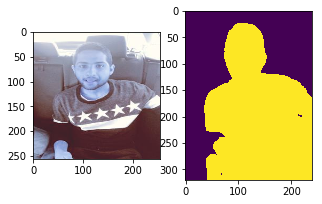

None 34


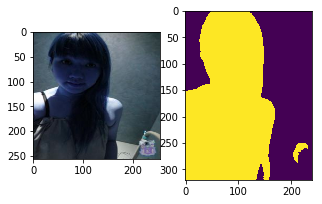

None 35


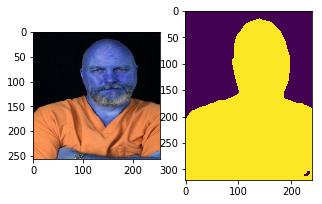

None 36


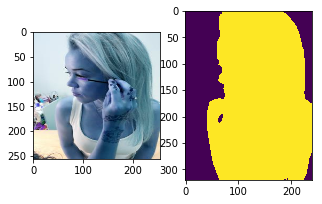

None 37


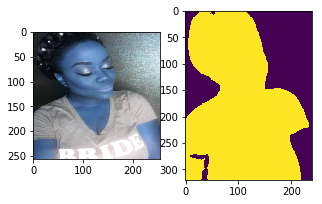

None 38


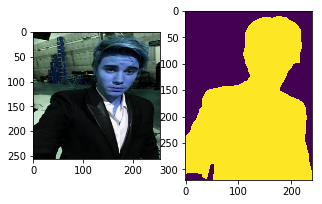

None 39


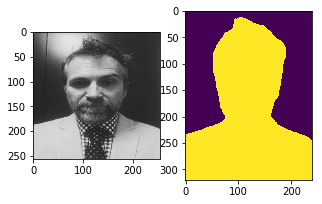

None 40


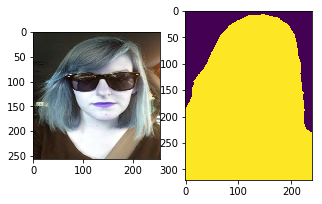

None 41


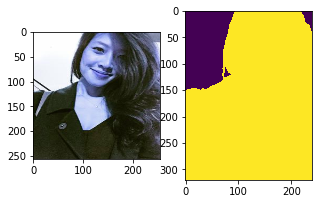

None 42


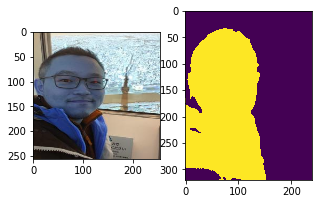

None 43


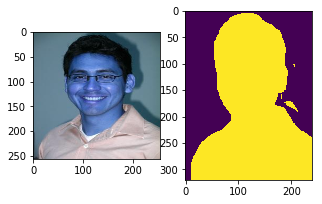

None 44


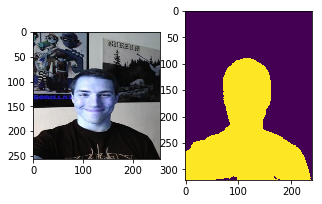

None 45


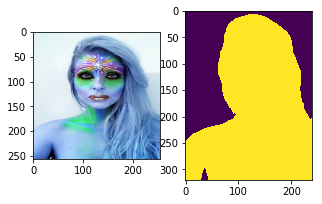

None 46


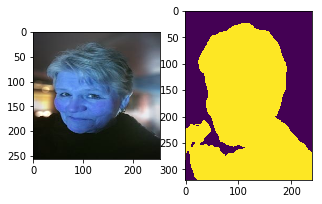

None 47


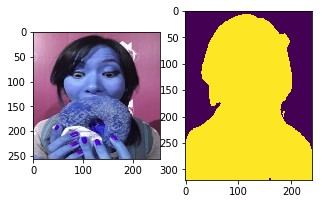

None 48


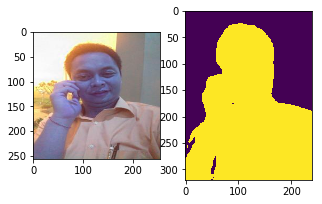

None 49


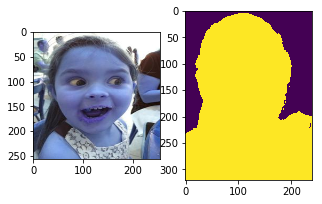

None 50


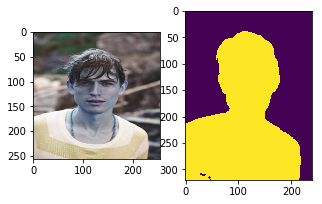

None 51


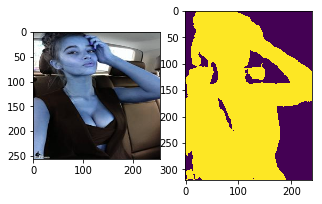

None 52


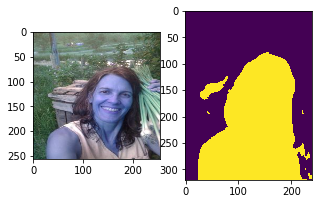

None 53


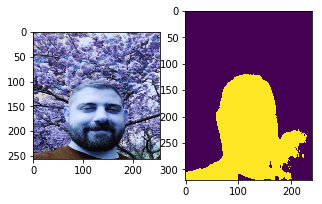

None 54


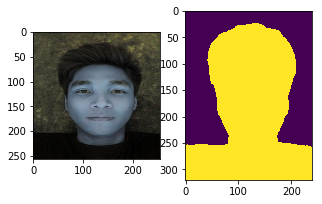

None 55


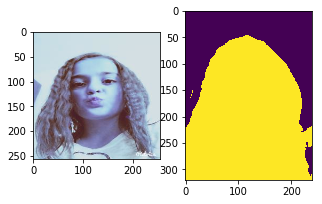

None 56


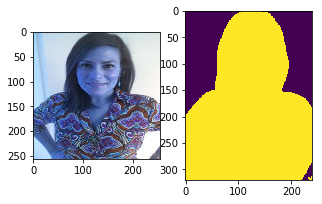

None 57


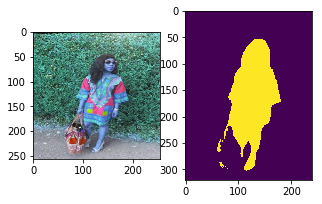

None 58


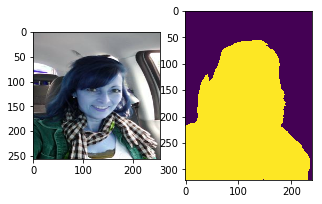

None 59


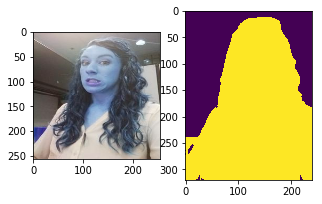

None 60


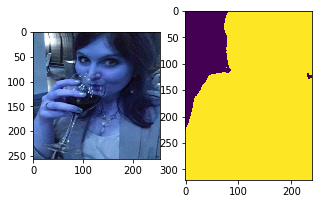

None 61


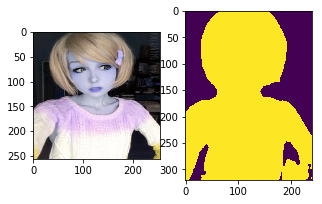

None 62


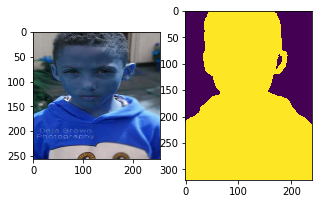

None 63


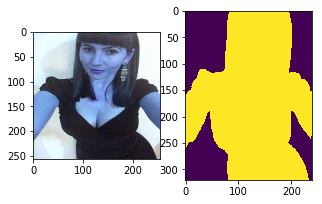

None 64


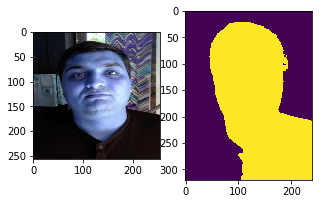

None 65


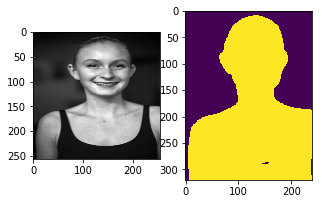

None 66


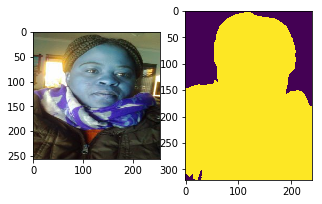

None 67


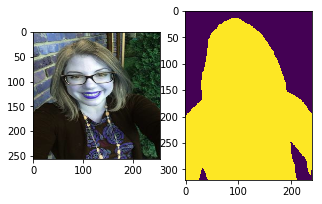

None 68


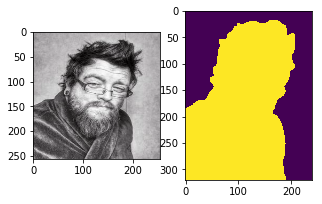

None 69


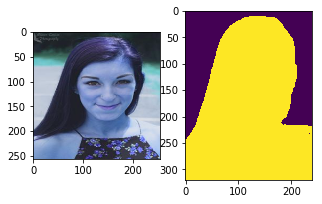

None 70


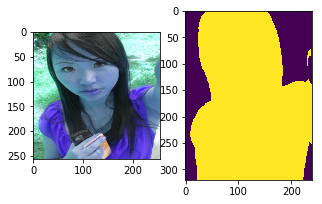

None 71


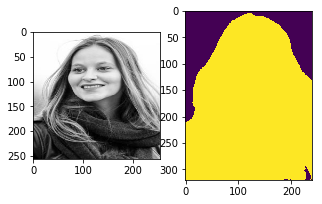

None 72


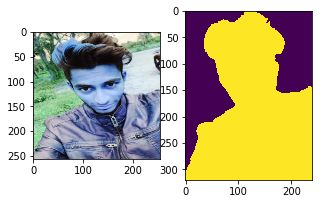

None 73


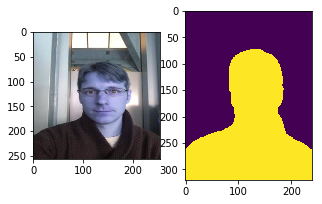

None 74


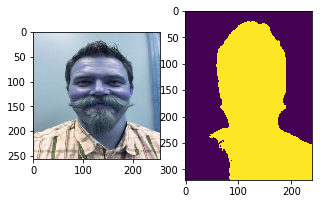

None 75


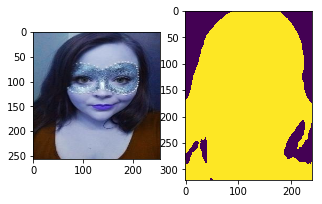

None 76


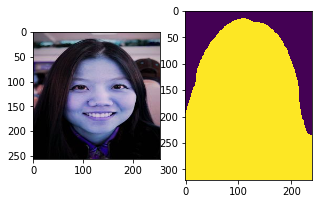

None 77


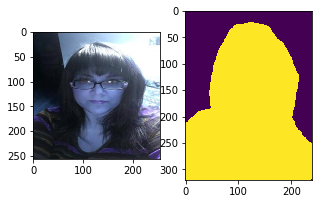

None 78


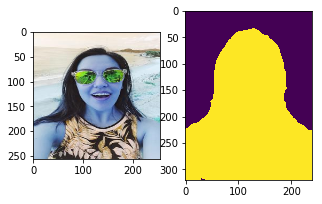

None 79


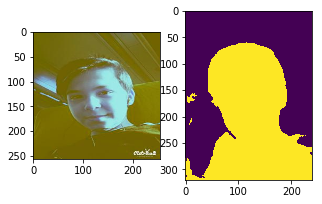

None 80


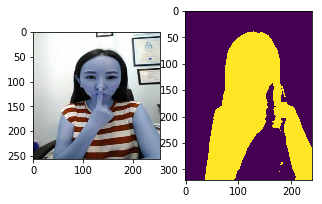

None 81


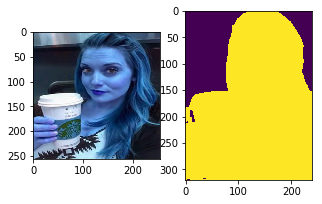

None 82


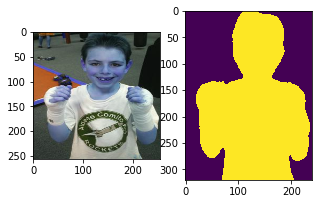

None 83


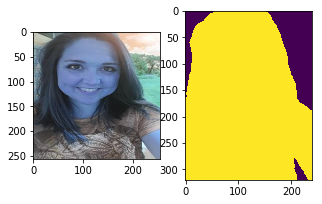

None 84


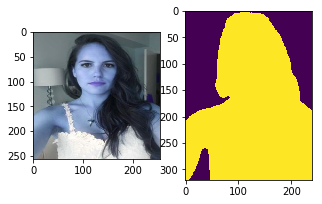

None 85


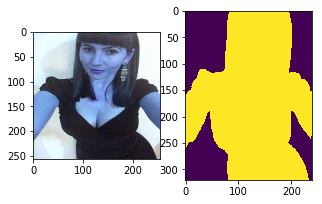

None 86


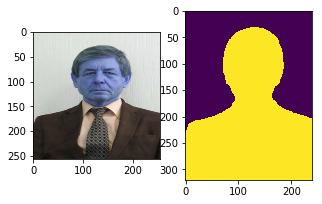

None 87


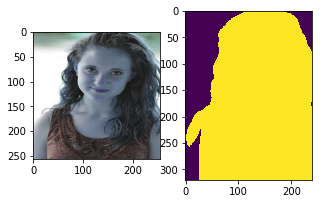

None 88


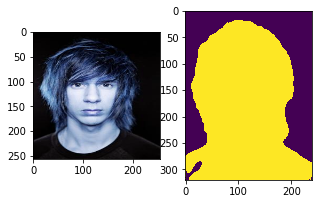

None 89


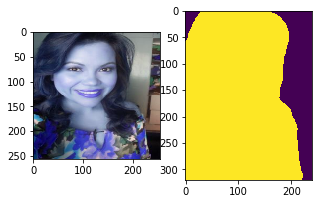

None 90


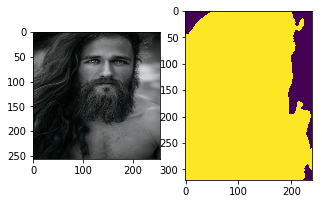

None 91


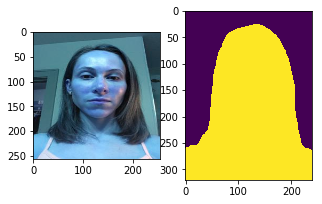

None 92


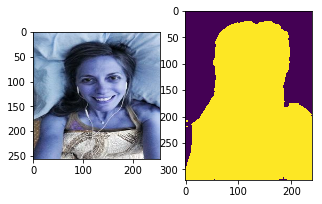

None 93


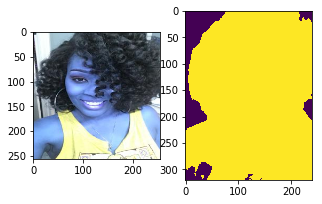

None 94


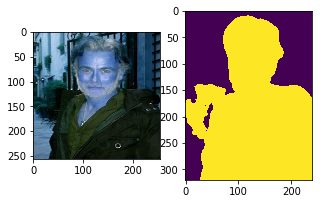

None 95


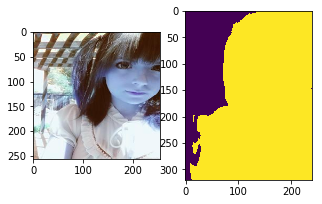

None 96


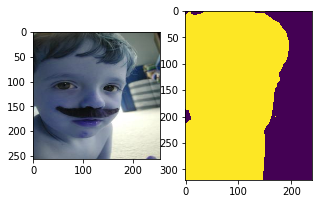

None 97


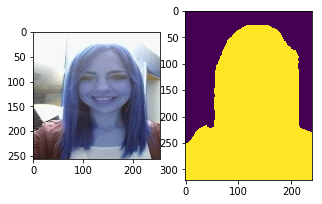

None 98


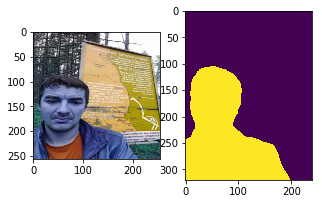

None 99


In [55]:
for im_id in range (100):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    axes[0].imshow(list_of_test[im_id])
    axes[1].imshow(pred_list_tests[im_id])

    print(plt.show(), im_id)

In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from glob import glob

from lib import *

%matplotlib inline
from glob import glob
from PIL import Image
from datetime import datetime

def generate_html(path_to_data):
    """Generates content of html file and saves it.
    Parameters
    ----------
    path_to_data : str
        Path to data with original images, predicted masks, and cropped according masks images.
    Returns
    -------
    str
        Content of html file.
    """
    html = "\n".join(["<!doctype html>", "<html>", "<head>",
                      "<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>",
                      "<title>Визуализация результатов</title>", "</head>", "<body>",
                      "<table cellspacing='0' cellpadding='5'>"]) + "\n"
    paths_to_imgs = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_img.jpg")])
    paths_to_masks = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_pred_mask.png")])
    paths_to_crops = sorted(
        ["/".join(path.split("/")[-2:]) for path in glob(f"{path_to_data}/*_crop.png")])
    for ind, (path_to_img, path_to_mask, path_to_crop) in enumerate(zip(paths_to_imgs,
                                                                        paths_to_masks,
                                                                        paths_to_crops)):
        if not ind % 2:
            html += "<tr>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_img}'"
        html += "alt='Something went wrong.'"
        html += f"height='320' title='Original image:\n{path_to_img}'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_mask}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Predicted mask'></td>\n"
        html += f"<td width='240' valign='top'><img src='{path_to_crop}'"
        html += "alt='Something went wrong.'"
        html += "height='320' title='Cropped img according\npredicted mask'></td>\n"
        if not ind % 2:
            html += "<td width='100'></td>\n"
        else:
            html += "</tr>\n"
    date = datetime.today().strftime("%Y-%m-%d-%H.%M.%S")
    html += f"</table>\n<i>The page was generated at {date}</i></body>\n</html>"
    filename = os.path.basename(path_to_data) + ".html"
    path_to_save = os.path.dirname(path_to_data)
    with open(f"{path_to_save}/{filename}", "w") as f:
        f.write(html)

    return html


def get_html(paths_to_imgs, pred_masks, path_to_save="results/test"):
    """Generates html file and saves it.
    Parameters
    ----------
    paths_to_imgs : list[str]
        List of paths to original images.
    pred_masks : list[np.ndarray]
        Predicted masks.
    path_to_save : str
        Path to save source images to put them in html file. Html name is the same as name of the
        last folder on `path_to_save` and is saved on upper level.
    Returns
    -------
    str
        Content of html file.
    """
    paths_to_imgs = np.array(paths_to_imgs)
    pred_masks = np.array(pred_masks)

    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)

    order = np.argsort(paths_to_imgs)
    paths_to_imgs = paths_to_imgs[order]
    pred_masks = pred_masks[order]

    for path_to_img, pred_mask in zip(paths_to_imgs, pred_masks):
        img_id = path_to_img.split("\\")[-1].split(".")[0]
        img = np.array(Image.open(path_to_img))
        Image.fromarray(img).save(f"{path_to_save}/{img_id}_img.jpg")
        Image.fromarray(pred_mask).save(f"{path_to_save}/{img_id}_pred_mask.png")
        crop_img = img.copy()
        crop_img[pred_mask == 0] = 0
        Image.fromarray(crop_img).save(f"{path_to_save}/{img_id}_crop.png")

    html = generate_html(path_to_save)

    return html

In [57]:
paths_to_img = sorted(glob("data/test/*"))
pred_masks = sorted(glob("data/test_mask/*"))

In [58]:
sorted(glob("data/test/*"))

['data/test\\1460.jpg',
 'data/test\\1461.jpg',
 'data/test\\1462.jpg',
 'data/test\\1463.jpg',
 'data/test\\1464.jpg',
 'data/test\\1465.jpg',
 'data/test\\1466.jpg',
 'data/test\\1467.jpg',
 'data/test\\1468.jpg',
 'data/test\\1469.jpg',
 'data/test\\1470.jpg',
 'data/test\\1471.jpg',
 'data/test\\1472.jpg',
 'data/test\\1473.jpg',
 'data/test\\1474.jpg',
 'data/test\\1475.jpg',
 'data/test\\1476.jpg',
 'data/test\\1477.jpg',
 'data/test\\1478.jpg',
 'data/test\\1479.jpg',
 'data/test\\1480.jpg',
 'data/test\\1481.jpg',
 'data/test\\1482.jpg',
 'data/test\\1483.jpg',
 'data/test\\1484.jpg',
 'data/test\\1485.jpg',
 'data/test\\1486.jpg',
 'data/test\\1487.jpg',
 'data/test\\1488.jpg',
 'data/test\\1489.jpg',
 'data/test\\1490.jpg',
 'data/test\\1491.jpg',
 'data/test\\1492.jpg',
 'data/test\\1493.jpg',
 'data/test\\1494.jpg',
 'data/test\\1495.jpg',
 'data/test\\1496.jpg',
 'data/test\\1497.jpg',
 'data/test\\1498.jpg',
 'data/test\\1499.jpg',
 'data/test\\1500.jpg',
 'data/test\\150

In [59]:
pred_masks = [np.array(Image.open(path)) for path in sorted(glob("data/test_mask/*"))]

In [60]:
pred_masks

[array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255,   0, ...,   0,   0, 255],
        [255, 255,   0, ...,   0,   0, 255],
        [255, 255,   0, ..., 255, 255, 255]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255

In [61]:
get_html(paths_to_img, pred_masks, path_to_save='results/test')

"<!doctype html>\n<html>\n<head>\n<meta http-equiv='Content-Type' content='text/html; charset=utf-8'>\n<title>Визуализация результатов</title>\n</head>\n<body>\n<table cellspacing='0' cellpadding='5'>\n<tr>\n<td width='240' valign='top'><img src='results/test\\1460_img.jpg'alt='Something went wrong.'height='320' title='Original image:\nresults/test\\1460_img.jpg'></td>\n<td width='240' valign='top'><img src='results/test\\1460_pred_mask.png'alt='Something went wrong.'height='320' title='Predicted mask'></td>\n<td width='240' valign='top'><img src='results/test\\1460_crop.png'alt='Something went wrong.'height='320' title='Cropped img according\npredicted mask'></td>\n<td width='100'></td>\n<td width='240' valign='top'><img src='results/test\\1461_img.jpg'alt='Something went wrong.'height='320' title='Original image:\nresults/test\\1461_img.jpg'></td>\n<td width='240' valign='top'><img src='results/test\\1461_pred_mask.png'alt='Something went wrong.'height='320' title='Predicted mask'></